# Buy/Not buy action predicted using LSTM

This notebook utilised LSTM to predict the buy or not buy action of a stock. The feature of the stock is the Open, High, Low, Close, Volume, Adj Close price of the stock. The target is the action of the stock, which is 1 if the stock price is higher than the previous day, and 0 if the stock price is lower than the previous day.

In [1]:
# import library for Support Vector Classification
from sklearn.svm import SVC

# import library for plot
import matplotlib.pyplot as plt

# import library for data handling
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# import library for pytorch
import torch
import torch.nn as nn

# import custom function
from stock_predict import SequenceDataset, ShallowRegressionLSTM, train, test, get_stock_data, split_train_test, predict_binary, split_train_test_binary, svc_train

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

input = torch.randn(2)
output = torch.sigmoid(input)
binary = torch.round(output)
print(input)
print(output)
print(binary)

tensor([1.7530, 0.4830])
tensor([0.8523, 0.6184])
tensor([1., 1.])


In [3]:
# Get the past stock price
df = get_stock_data(stock_name = 'TSLA', source = 'yahoo', past_year = 2)

In [4]:
features = df.columns

In [5]:
features

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [6]:
# set up train and test data
train_df, test_df, train_size, test_size, df['perfect'] = split_train_test_binary(df,0.7)


In [7]:
test_df

,High,Low,Open,Close,Volume,Adj Close,perfect
Date,,,,,,,
2022-02-24,0.190307,-0.166203,-0.251247,0.272591,0.872835,0.272591,1
2022-02-25,0.276160,0.276097,0.313158,0.319927,-0.306428,0.319927,1
2022-02-28,0.565498,0.449528,0.343131,0.634950,0.150100,0.634950,0
2022-03-01,0.631174,0.659245,0.626630,0.603426,-0.332316,0.603426,1
2022-03-02,0.614024,0.608198,0.639335,0.684159,-0.334776,0.684159,0
...,...,...,...,...,...,...,...
2022-09-26,0.441460,0.429238,0.345620,0.414392,-0.664475,0.414392,1
2022-09-27,0.510768,0.545181,0.532459,0.522538,-0.587888,0.522538,1
2022-09-28,0.515762,0.546147,0.520635,0.598537,-0.732382,0.598537,0


In [8]:
# create dataset and dataloader
batch_size = 5
seq_len = 20

torch.manual_seed(seq_len*batch_size/2)

train_dataset = SequenceDataset(train_df, 'perfect', features, seq_len)
test_dataset = SequenceDataset(test_df, 'perfect', features, seq_len)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get the first batch of data to check the shape
x, y = next(iter(train_loader))
print("Feature shape: ", x.shape)
print("Target shape: ", y.shape)

Feature shape:  torch.Size([5, 20, 6])
Target shape:  torch.Size([5])


In [9]:
# create model, loss and optimizer
learning_rate = 5e-5
num_hidden = 8
num_layers = 1
epoch = 100

model = ShallowRegressionLSTM(n_features = len(features), n_hidden = num_hidden, n_layers = num_layers, device = device).to(device)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# train and test
print("Untrained test")
test(model, test_loader, loss, device)

print("Training")
for i in range(epoch):
    print("Epoch: " + str(i+1))
    train(model, train_loader, loss, optimizer, device)
    test(model, test_loader, loss, device)



Untrained test
Test loss: 0.7106
Training
Epoch: 1
Train loss: 0.7107
Test loss: 0.7101
Epoch: 2
Train loss: 0.7102
Test loss: 0.7097
Epoch: 3
Train loss: 0.7101
Test loss: 0.7092
Epoch: 4
Train loss: 0.7087
Test loss: 0.7087
Epoch: 5
Train loss: 0.7085
Test loss: 0.7082
Epoch: 6
Train loss: 0.7079
Test loss: 0.7078
Epoch: 7
Train loss: 0.7081
Test loss: 0.7075
Epoch: 8
Train loss: 0.7072
Test loss: 0.7069
Epoch: 9
Train loss: 0.7064
Test loss: 0.7065
Epoch: 10
Train loss: 0.7056
Test loss: 0.7061
Epoch: 11
Train loss: 0.7056
Test loss: 0.7057
Epoch: 12
Train loss: 0.7054
Test loss: 0.7053
Epoch: 13
Train loss: 0.7045
Test loss: 0.7049
Epoch: 14
Train loss: 0.7047
Test loss: 0.7045
Epoch: 15
Train loss: 0.7035
Test loss: 0.7041
Epoch: 16
Train loss: 0.7033
Test loss: 0.7038
Epoch: 17
Train loss: 0.7030
Test loss: 0.7034
Epoch: 18
Train loss: 0.7021
Test loss: 0.7030
Epoch: 19
Train loss: 0.7021
Test loss: 0.7026
Epoch: 20
Train loss: 0.7020
Test loss: 0.7023
Epoch: 21
Train loss: 0.701

In [11]:
# make prediction
train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

train_df["pred_action"] = predict_binary(train_eval, model, device)
test_df["pred_action"] = predict_binary(test_loader, model, device)

df_out = pd.concat([train_df, test_df], axis=0)

<AxesSubplot:xlabel='Date'>

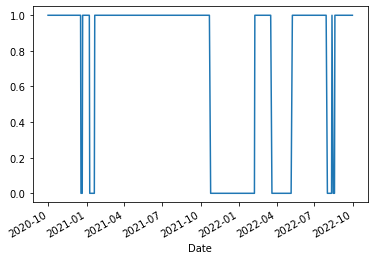

In [12]:
#plot pred action
df_out['pred_action'].plot()

<AxesSubplot:xlabel='Date'>

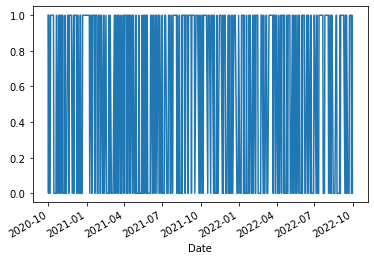

In [13]:
df_out['perfect'].plot()

In [14]:
# make random decision
df_out["random_action"] = np.random.randint(0,2,df_out.shape[0])

print(df_out['random_action'])

Date
2020-09-30    0
2020-10-01    1
2020-10-02    0
2020-10-05    1
2020-10-06    0
             ..
2022-09-26    0
2022-09-27    0
2022-09-28    0
2022-09-29    0
2022-09-30    1
Name: random_action, Length: 505, dtype: int64


In [15]:
# Calculate the daily returns from the stock
df_out['returns'] = df_out['Close'].pct_change(1)
# Show the returns
df_out['returns']

Date
2020-09-30         NaN
2020-10-01   -0.059964
2020-10-02    0.110157
2020-10-05   -0.031775
2020-10-06    0.036258
                ...   
2022-09-26    0.026282
2022-09-27    0.260974
2022-09-28    0.145441
2022-09-29   -0.511025
2022-09-30    0.154631
Name: returns, Length: 505, dtype: float64

In [16]:
# Calculate the strategy returns
df_out['strategy_returns'] = df_out['pred_action'].shift(1) * df_out['returns']
# Show the strategy returns
df_out['strategy_returns']

Date
2020-09-30         NaN
2020-10-01   -0.059964
2020-10-02    0.110157
2020-10-05   -0.031775
2020-10-06    0.036258
                ...   
2022-09-26    0.026282
2022-09-27    0.260974
2022-09-28    0.145441
2022-09-29   -0.511025
2022-09-30    0.154631
Name: strategy_returns, Length: 505, dtype: float64

In [17]:
# Calculate the cumulative strategy returns
df_out['cum_strategy_returns'] = df_out['strategy_returns'].cumsum()
# Show the cumulative strategy returns
df_out['cum_strategy_returns']

Date
2020-09-30          NaN
2020-10-01    -0.059964
2020-10-02     0.050193
2020-10-05     0.018418
2020-10-06     0.054676
                ...    
2022-09-26   -21.681206
2022-09-27   -21.420232
2022-09-28   -21.274791
2022-09-29   -21.785816
2022-09-30   -21.631185
Name: cum_strategy_returns, Length: 505, dtype: float64

In [18]:
# Calculate the random returns
df_out['random_returns'] = df_out['random_action'].shift(1) * df_out['returns']
# Calculate the cumulative random returns
df_out['cum_random_returns'] = df_out['random_returns'].cumsum()


In [19]:
# train svc model
svc_model = svc_train(df_out)

# make prediction
df_out['High-Low'] = df_out['High'] - df_out['Low']
df_out['Open-Close'] = df_out['Open'] - df_out['Close']
df_out['svc_action'] = svc_model.predict(df_out[['Open-Close', 'High-Low']])

<AxesSubplot:xlabel='Date'>

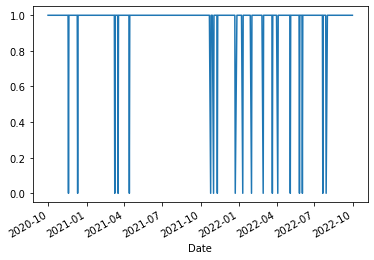

In [20]:
df_out['svc_action'].plot()

In [21]:
# Calculate the svc returns
df_out['svc_returns'] = df_out['svc_action'].shift(1) * df_out['returns']
# Calculate the cumulative svc returns
df_out['cum_svc_returns'] = df_out['svc_returns'].cumsum()

In [22]:
# Calculate market returns
df_out['market_returns'] = df_out['returns'].cumsum()

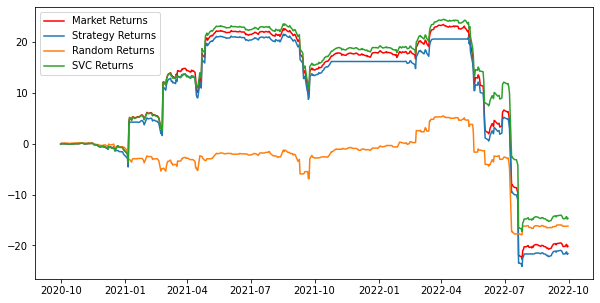

In [23]:
# plot returns
plt.figure(figsize=(10,5))
plt.plot(df_out['market_returns'], color='r', label='Market Returns')
plt.plot(df_out['cum_strategy_returns'], label='Strategy Returns')
plt.plot(df_out['cum_random_returns'], label='Random Returns')
plt.plot(df_out['cum_svc_returns'], label='SVC Returns')
plt.legend()
plt.show()